## Investigating LDA on Short, Specific Docmuments with Health News Tweets

The goal of this project was to 1) use LDA on shorter data like tweets within a specific domain, and 2) identify differences in predominant topics and their salience with smaller subsets of women's health news, men's health news, and health news related to children. The health news tweets were obtained from the UCI ML Repository, and contain tweets from several different news sources. This analysis uses the cleaned Reuters dataset due to its size and global news coverage.

#### Imports and Helper Functions

Each of the functions are commented for easy reproducability and readability. Helper functions are used to build functions that preprocess the text file containing the data, visualize coherence plots for topics ranging from 2-15 (this was generally found to be a useful range given the size of the datasets), and to plot the results of the LDA topics and terms within them.

In [27]:
# all necessary imports
import pandas as pd
import numpy as np
import re
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import spacy
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from gensim.models import CoherenceModel
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# uncomment and use to update if not recently updated
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [28]:
# create dataframe from file path 

# load in data
def read_text(file_path):
    file = open(file_path)
    file_lines = file.readlines()
    return file_lines

# create the df from the text lines (to preprocess and make it usable for LDA)
def file_lines_to_df(file_path):
    file_lines = read_text(file_path)
    df_file_lines = {'file_lines': file_lines}
    df = pd.DataFrame(df_file_lines)
    return df

In [29]:
# cleaning data, tokenizing, lemmatizing
def text_prep(text):
    text = re.sub('\s+', ' ', text)  # Remove extra spaces
    text = re.sub('\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text

def prep_df(df):
    df['cleaned_lines'] = df['file_lines'].apply(text_prep)
    return df

def tokenize(text):
    # download and add stopwords from nltk
    stop_words = stopwords.words('english')
    stop_words += ['may', 'say', 'use']
    # text tokenizers
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def tokenize_df(df):
    df['tokens'] = df['cleaned_lines'].apply(tokenize)
    return df  

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def lemmatize_df(df):
    df['lemmas'] = df['tokens'].apply(lemmatize)
    return df

def create_df_for_lda(df):
    df = prep_df(df)
    df = tokenize_df(df)
    df = lemmatize_df(df)
    return df

<>:3: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\S'
<>:3: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\S'
/var/folders/0_/jxh577k50pn0gjfk0m3vz0ch0000gn/T/ipykernel_60783/2332005278.py:3: DeprecationWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)  # Remove extra spaces
/var/folders/0_/jxh577k50pn0gjfk0m3vz0ch0000gn/T/ipykernel_60783/2332005278.py:4: DeprecationWarning: invalid escape sequence '\S'
  text = re.sub('\S*@\S*\s?', '', text)  # Remove emails


In [30]:
# to check coherence scores, we create a dictionary and a corpus
#print(df.head())
def create_id2word(df):
    id2word = gensim.corpora.Dictionary(df['lemmas'])
    return id2word

def create_corpus(df):
    id2word = create_id2word(df)
    texts = df['lemmas']
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus
    
def coherence_check(df):
    
    id2word = create_id2word(df)
    corpus = create_corpus(df)
    
    # checking coherence scores for 2-15 topics
    n = []
    coherence_scores = []
    for i in range(2, 15):
        n.append(i)
        # build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=i, 
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df['lemmas'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)
        
    # create dataframe of coherence scores with respective ns
    coherence_df = pd.DataFrame()
    coherence_df['n'] = n
    coherence_df['coherence_score'] = coherence_scores

    # plot coherence scores and display it to see elbow point
    sns.lineplot(coherence_df, x='n', y='coherence_score')
    plt.show()

    # find maximum coherence score
    row = coherence_df.iloc[coherence_df['coherence_score'].idxmax(axis=0)]
    print('Maximum Coherence found at n:')
    print(row)
    print(row['n'])

    # return number of topics n with max coherence
    return int(row['n'])

In [31]:
def build_lda(df, num_topics):
    # build model for number of topics from elbow method or max coherence method
    lda_model = gensim.models.ldamodel.LdaModel(corpus=create_corpus(df),
                                                id2word=create_id2word(df),
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    # print out the topics with 5 words and their salience for each topic
    topics = lda_model.print_topics(num_words = 5)
    for topic in topics:
        print(topic)

    return lda_model    

def show_lda_vis(df, num_topics):
    lda_model = build_lda(df, num_topics)
    corpus = create_corpus(df)
    id2word = create_id2word(df)

    # usign pyLDAvis to show interactive LDA visualization
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
    vis

    return vis

In [32]:
def keyword_filter_df(df, keywords):
    lemmas_subset = []
    for i in df['lemmas']:
        for j in i:
            if j in keywords and i not in lemmas_subset:
                lemmas_subset += [i]
    print(f'Number of tweets after filtering: {len(lemmas_subset)}')

    filt_lem_df = pd.DataFrame()
    filt_lem_df['lemmas'] = lemmas_subset

    return filt_lem_df

#### Analysis: Running functions on entire Reuters health news dataset

In [33]:
# running functions on all the reuters health text data
file_path = "health_news_clustering/cleaned_text_files/cleaned_reuters_health.txt"
df = file_lines_to_df(file_path)
df = create_df_for_lda(df)
df.head()

,file_lines,cleaned_lines,tokens,lemmas
0,Los Angeles closes 500 medical marijuana shops...,los angeles closes medical marijuana shops...,"[los, angeles, closes, medical, marijuana, sho...","[los, angeles, close, medical, marijuana, shop..."
1,U.S. cuts poultry export forecast as deadly bi...,u s cuts poultry export forecast as deadly bi...,"[cuts, poultry, export, forecast, deadly, bird...","[cut, poultry, export, forecast, deadly, bird,..."
2,Fears over Roundup herbicide residues prompt p...,fears over roundup herbicide residues prompt p...,"[fears, roundup, herbicide, residues, prompt, ...","[fear, roundup, herbicide, residue, prompt, pr..."
3,Liberia watchdog says some Ebola funds unaccou...,liberia watchdog says some ebola funds unaccou...,"[liberia, watchdog, says, ebola, funds, unacco...","[liberia, watchdog, say, ebola, fund, unaccounte]"
4,Diabetes devices may interfere with avalanche ...,diabetes devices may interfere with avalanche ...,"[diabetes, devices, interfere, avalanche, beac...","[diabetes, device, interfere, avalanche, beaco..."


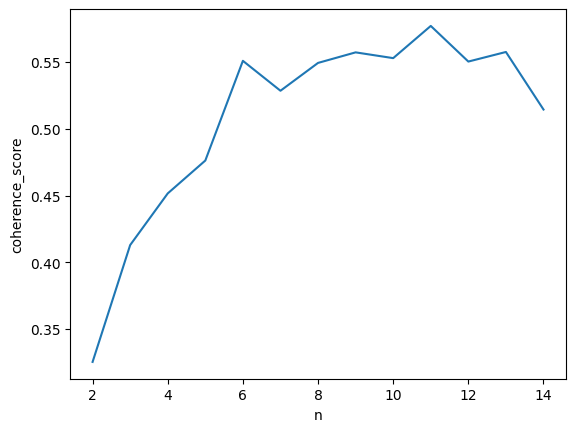

Maximum Coherence found at n:
n                  11.00000
coherence_score     0.57713
Name: 9, dtype: float64
11.0


11

In [34]:
coherence_df = coherence_check(df)
coherence_df

From looking at the coherence plots and getting the number of topics with maximum coherence, we see that n = 11 gives us the highest coherence. However, from the coherence plot, it looks like the coherence score plateaus around n = 6 onwards, with small increases. After plotting both values of n and investigating each of the topics further, the principal component axes 1 and 2 seem to overlap for several of the circles in the intertopic space.

In [35]:
show_lda_vis(df, 11)

(0, '0.098*"study" + 0.054*"cancer" + 0.043*"anthrax" + 0.038*"rt" + 0.036*"cdc"')
(1, '0.064*"tie" + 0.049*"high" + 0.048*"heart" + 0.044*"medical" + 0.035*"marijuana"')
(2, '0.234*"ebola" + 0.051*"case" + 0.036*"africa" + 0.032*"hospital" + 0.031*"sierra"')
(3, '0.057*"outbreak" + 0.055*"west" + 0.045*"scientist" + 0.040*"report" + 0.035*"allow"')
(4, '0.158*"drug" + 0.055*"fda" + 0.031*"trial" + 0.023*"get" + 0.016*"make"')
(5, '0.108*"say" + 0.041*"virus" + 0.037*"liberia" + 0.030*"uk" + 0.022*"million"')
(6, '0.028*"man" + 0.028*"lab" + 0.023*"warning" + 0.023*"food" + 0.023*"top"')
(7, '0.027*"fight" + 0.025*"court" + 0.024*"woman" + 0.024*"back" + 0.022*"become"')
(8, '0.082*"new" + 0.041*"doctor" + 0.038*"obamacare" + 0.032*"york" + 0.020*"approve"')
(9, '0.053*"health" + 0.045*"patient" + 0.040*"ebola" + 0.032*"exclusive" + 0.032*"test"')
(10, '0.072*"risk" + 0.061*"link" + 0.041*"help" + 0.038*"recall" + 0.030*"kid"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.296531 -0.019535       1        1  13.693267
2      0.267576 -0.015029       2        1  11.908450
0     -0.093492 -0.387451       3        1  11.131662
4     -0.077226  0.095883       4        1   9.971355
7     -0.064790  0.056225       5        1   9.489282
5     -0.067968  0.062102       6        1   9.268246
8     -0.064715  0.056306       7        1   8.265779
10    -0.056476  0.044505       8        1   7.718241
6     -0.047121  0.036264       9        1   6.957721
1     -0.048725  0.037296      10        1   5.984303
3     -0.043596  0.033434      11        1   5.611694, topic_info=        Term         Freq        Total Category  logprob  loglift
23     ebola  1166.000000  1166.000000  Default  30.0000  30.0000
203     drug   550.000000   550.000000  Default  29.0000  29.0000
400    study   382.000000   382.000000  Default  28.0000  28.0000
26       say   350.000000   350.000000  Default  27.0000  27.0000
154      new   238.000000   238.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
945     amid    15.141042    16.053661  Topic11  -4.8629   2.8218
1111  affect    14.813389    15.726039  Topic11  -4.8848   2.8205
294   launch    14.767303    15.679924  Topic11  -4.8879   2.8204
1467    many    14.728432    15.641049  Topic11  -4.8905   2.8202
933      ill    13.876333    14.788945  Topic11  -4.9501   2.8166

[362 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
112       5  0.980536  abortion
846      11  0.963649     abuse
3790     11  0.984012  academia
1097      9  0.961137     adult
1111     11  0.953832    affect
...     ...       ...       ...
507       5  0.971272     world
156       7  0.982184      year
489       7  0.985602      york
689       8  0.977833     young
1203     10  0.980535     youth

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 1, 5, 8, 6, 9, 11, 7, 2, 4])

In [36]:
show_lda_vis(df, 6)

(0, '0.029*"anthrax" + 0.028*"link" + 0.023*"virus" + 0.021*"find" + 0.018*"recall"')
(1, '0.030*"tie" + 0.023*"high" + 0.017*"get" + 0.016*"court" + 0.011*"aid"')
(2, '0.040*"risk" + 0.021*"sierra" + 0.019*"leone" + 0.014*"become" + 0.013*"first"')
(3, '0.049*"health" + 0.033*"cdc" + 0.028*"state" + 0.026*"outbreak" + 0.025*"hospital"')
(4, '0.076*"drug" + 0.027*"fda" + 0.020*"rt" + 0.017*"exclusive" + 0.016*"obamacare"')
(5, '0.097*"ebola" + 0.040*"study" + 0.035*"say" + 0.026*"new" + 0.022*"cancer"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.361779 -0.046120       1        1  29.814813
4      0.123509 -0.318189       2        1  18.830026
0      0.069604  0.152012       3        1  14.608389
2      0.054593  0.077536       4        1  13.113727
3      0.051866  0.056349       5        1  12.083983
1      0.062207  0.078412       6        1  11.549062, topic_info=           Term         Freq        Total Category  logprob  loglift
23        ebola  1005.000000  1005.000000  Default  30.0000  30.0000
203        drug   502.000000   502.000000  Default  29.0000  29.0000
400       study   416.000000   416.000000  Default  28.0000  28.0000
197      health   208.000000   208.000000  Default  27.0000  27.0000
26          say   367.000000   367.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3558  cognitive    28.646542    29.516175   Topic6  -4.9470   2.1287
1394        bay    30.053668    31.104284   Topic6  -4.8991   2.1242
5217      detox    29.385130    30.854822   Topic6  -4.9216   2.1098
5218      ditch    29.385130    30.854822   Topic6  -4.9216   2.1098
5219     techie    29.385130    30.854822   Topic6  -4.9216   2.1098

[216 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1379      1  0.993207    africa
414       6  0.980114       aid
490       6  0.974808       air
2314      6  0.979270  allergan
787       2  0.991267     allow
...     ...       ...       ...
507       4  0.987895     world
156       1  0.993602      year
489       1  0.993305      york
689       1  0.986865     young
1203      6  0.986198     youth

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 3, 4, 2])

Based on these visuals and looking through the topics in each of them, there does seem to be a fair amount of semantic overlap between topics 3 through 6, making it difficult to identify what separates these topics and by how much. Moreover, while looking through the overall term frequencies in the intertopic scale, some of the salient terms such as 'cdc' appear to be in the same space on the axes of PC1 and PC2, covering the space of the other topics from 3 through 6. Based on these intuitions, switching the number of topics to 3 makes them much more disjoint in the intertopic distance map on the PC1 and PC2 axes. The interpretability of these 3 topics also improves significantly. This is an interesting demonstration of why coherence scores may not be the best metric to identify the ideal number of topics in the case of shorter documents within a specifc topic.

In [37]:
show_lda_vis(df, 3)

(0, '0.019*"new" + 0.016*"health" + 0.014*"risk" + 0.013*"case" + 0.012*"anthrax"')
(1, '0.042*"drug" + 0.029*"study" + 0.016*"cancer" + 0.015*"fda" + 0.011*"tie"')
(2, '0.087*"ebola" + 0.031*"say" + 0.016*"patient" + 0.012*"doctor" + 0.012*"test"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.177375  0.203452       1        1  34.548629
1     -0.269312  0.048117       2        1  32.909667
2      0.091938 -0.251569       3        1  32.541704, topic_info=            Term        Freq       Total Category  logprob  loglift
23         ebola  984.000000  984.000000  Default  30.0000  30.0000
203         drug  481.000000  481.000000  Default  29.0000  29.0000
26           say  359.000000  359.000000  Default  28.0000  28.0000
400        study  335.000000  335.000000  Default  27.0000  27.0000
154          new  225.000000  225.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1363        west  108.037180  112.246618   Topic3  -4.6555   1.0844
2006   screening   46.950621   47.757267   Topic3  -5.4889   1.1056
832         lack   48.996864   49.980670   Topic3  -5.4462   1.1028
184       become   68.090280   70.950176   Topic3  -5.1171   1.0815
612   antibiotic   63.762340   66.596530   Topic3  -5.1828   1.0792

[138 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1379      3  0.998058  africa
414       2  0.985580     aid
414       3  0.020970     aid
787       1  0.986267   allow
787       2  0.016438   allow
...     ...       ...     ...
532       3  0.989947   woman
412       3  0.991570  worker
156       1  0.982986    year
489       1  0.997135    york
689       2  0.988972   young

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

As seen in the visualization with 3 topics, Topic 1 seems to be generally about public health and disease, with words like 'risk', 'case', and 'outbreak' having highest frequency within this topic. Topic 2 seems more oriented towards testing and studying of medication, with high frequency terms including 'drug', 'study', and 'fda'. Meanwhile, Topic 3 seems to be about diseases in Africa, with the highest frequency term being 'ebola', and other high frequency terms including 'africa', 'liberia', 'sierra', and 'leone'. These topics are fairly easy to interpret as distinct from each other, showing that LDA can still be effective on smaller documents such as tweets, within a specific domain. Choosing the number of topics to be 3 based on the intertopic distance visualizations was helpful to find an interpretable number of topics in this case.

#### Expanding Analyses on Data Subsets with Topic Modeling

After finding LDA to be fairly effective on this data, an interesting area of analysis would be subsetting the data even further into narrower topics. Analyzing the differences in the salient topics and their highest frequency terms across these subsets would help to understand LDA effectiveness on even more specific datasets which are also smaller due to keyword filtering for topics, and to understand differences across subtopics. The keyword subsets were chosen to find tweets focused on women's health news, men's health news, and children's health news.

#### Women's Health News Subset

In [40]:
# women's health news subset

# creating list of keywords used to identify relevant tweets
keywords = [
    'women', 'woman', 'female', 'menstrual', 'menstruation', 'abortion',
    "women's", 'girl', 'lady', 'birth', 'menopause', 'mother', 'mom', 'childbirth',
    'ladies', 'ovulation', 'uterus', 'breast', 'ovar', 'ovary', 'ovarian'
]

women_df = keyword_filter_df(df, keywords)
women_df.head()

Number of tweets after filtering: 207


,lemmas
0,"[oklahoma, set, join, kansas, ban, flashpoint,..."
1,"[memory, suffer, mother, care, disabled, child]"
2,"[kansas, become, first, state, ban, second, tr..."
3,"[breast, milk, sell, online, contain, cow, milk]"
4,"[kenya, court, urge, change, law, criminalize,..."


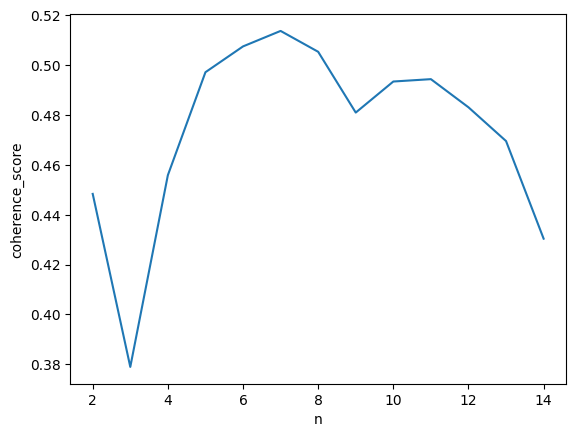

Maximum Coherence found at n:
n                  7.000000
coherence_score    0.513626
Name: 5, dtype: float64
7.0


7

In [41]:
w_coherence_df = coherence_check(women_df)
w_coherence_df

Based on the coherence plot, the coherence seems to plateau around n = 5, so the LDA visualization is done with 5 topics. Looking at 2, 4, and 7 topics, setting n = 5 gave the most interpretable set of topics, and the highest frequency terms within them seemed to be interconnected. Only topic 5 had low frequencies for most of the terms within the topic, and the topic was harder to explain. Trying to absorb this topic into another by reducing n to 4, however, resulted in less clarity across the other topics as well.

In [50]:
show_lda_vis(women_df, 5)

(0, '0.068*"cancer" + 0.043*"roche" + 0.040*"breast" + 0.037*"drug" + 0.034*"pill"')
(1, '0.058*"birth" + 0.046*"ovarian" + 0.043*"baby" + 0.039*"eu" + 0.035*"read"')
(2, '0.073*"woman" + 0.062*"study" + 0.041*"risk" + 0.033*"mother" + 0.031*"young"')
(3, '0.081*"abortion" + 0.061*"law" + 0.039*"court" + 0.033*"woman" + 0.028*"massachusetts"')
(4, '0.054*"top" + 0.016*"woman" + 0.012*"female" + 0.010*"mom" + 0.009*"restriction"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.044855 -0.210554       1        1  30.461689
2      0.204475  0.123605       2        1  21.848801
1     -0.067164  0.041056       3        1  17.948257
0     -0.178856  0.073602       4        1  16.833390
4     -0.003310 -0.027710       5        1  12.907862, topic_info=         Term       Freq      Total Category  logprob  loglift
0    abortion  39.000000  39.000000  Default  30.0000  30.0000
31        law  29.000000  29.000000  Default  29.0000  29.0000
100     study  22.000000  22.000000  Default  28.0000  28.0000
111     birth  16.000000  16.000000  Default  27.0000  27.0000
73     cancer  23.000000  23.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
79       girl   0.934939   3.961862   Topic5  -5.3608   0.6033
458     drive   0.772286   3.335682   Topic5  -5.5519   0.5843
50       link   0.680614   2.998687   Topic5  -5.6783   0.5644
0    abortion   0.796051  39.273184   Topic5  -5.5216  -1.8513
27      court   0.649295  19.238496   Topic5  -5.7254  -1.3414

[215 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.967581  abortion
0         5  0.025463  abortion
425       3  0.672694   african
719       4  0.942487    agency
722       3  0.985861     aloud
...     ...       ...       ...
344       2  0.386218     women
344       3  0.386218     women
192       1  0.774449      year
192       2  0.258150      year
47        2  0.912861     young

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

Looking at the visualizations themselves, the topics are generally interpretable. Topic 1 has abortion as the most relevant term for that topic, with words like 'law', 'court' and 'strike' being frequent terms. Topic 2 seems to be tied to disease and studies that were about women specifically, with 'woman' being the highest frequency term and other frequent words including 'study', 'obese', and 'depression'. Topic 3 has 'birth' and 'baby' as some of the most frequent terms, and words like 'pediatrician' and 'cancer' appear, making this topic most likely about infant and baby health and disease. Topic 4 is about cancers and their treatments, with the highest frequency term being 'cancer', and terms like 'drug' and 'pill' are frequent, as well as 'roche' and 'avastin'. Roche is a pharmaceutical company that provides cancer treatments, and Avastin is a cancer drug designed to work with chemotherapy. Topic 5 was harder to interpret, with 'top' being the most relevant and highest frequency term in the topic, while the other topics were more spread out, although words like 'restriction' and 'pregnancy' had higher term frequencies in this topic than others.

#### Men's Health News Subset

In [46]:
# men's health news subset

# creating list of keywords used to identify relevant tweets
keywords = [
    'men', 'man', 'male', 'testicular', 'prostate', 'sperm',
    "men's", 'erectile', 'gentleman', 'semen', 'penile', 'penis', 'vasectomy', 'gentlemen',
    'erection', 'testes'
]

men_df = keyword_filter_df(df, keywords)
men_df.head()

Number of tweets after filtering: 85


,lemmas
0,"[erectile, dysfunction, drug, vary, effectiven..."
1,"[old, man, exercise, well, erectile, function]"
2,"[pesticide, fruit, veggie, link, poor, semen, ..."
3,"[occupational, exposure, chemical, lymphoma, r..."
4,"[exclusive, drug, cause, elephant, man, side, ..."


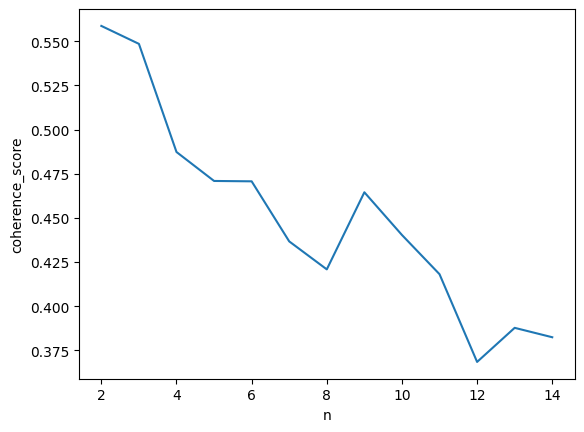

Maximum Coherence found at n:
n                  2.000000
coherence_score    0.558651
Name: 0, dtype: float64
2.0


2

In [49]:
m_coherence_df = coherence_check(men_df)
m_coherence_df

Interestingly, the highest coherence and what would typically be the 'elbow' point are the same for this coherence plot: at number of topics n = 2. This could be due to the narrow subtopic of men's health news tweets not having much diversity of terms, leading to the most reasonable number of topics being smaller, or similarly due to how small this subset of the data is, with only 85 tweets to analyze. Plotting the LDA 

In [51]:
show_lda_vis(men_df, 2)

(0, '0.058*"man" + 0.023*"risk" + 0.017*"gay" + 0.016*"cancer" + 0.016*"among"')
(1, '0.062*"man" + 0.029*"prostate" + 0.028*"ebola" + 0.027*"cancer" + 0.024*"test"')


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.075148  0.0       1        1  50.738904
1     -0.075148  0.0       2        1  49.261096, topic_info=       Term       Freq      Total Category  logprob  loglift
160    test   7.000000   7.000000  Default  30.0000  30.0000
125   among   5.000000   5.000000  Default  29.0000  29.0000
84      gay   5.000000   5.000000  Default  28.0000  28.0000
39     male   5.000000   5.000000  Default  27.0000  27.0000
23     risk   8.000000   8.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
57   cancer   8.080613  13.042841   Topic2  -3.6143   0.2293
9       man  18.674999  36.548895   Topic2  -2.7766   0.0366
117   virus   2.293135   3.258665   Topic2  -4.8739   0.3566
155     say   2.218522   3.259213   Topic2  -4.9069   0.3234
119  deadly   1.624952   2.608446   Topic2  -5.2183   0.2348

[110 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
125       1  0.954509          among
66        2  1.023847           area
111       1  1.018924        benefit
126       1  0.916583       bisexual
250       2  1.023841         boston
...     ...       ...            ...
117       1  0.306874          virus
117       2  0.613748          virus
322       2  1.023501  vulnerability
105       1  0.872765          woman
82        1  0.763966          young

[94 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Looking at the topics, there are clear distinctions between each of them. Topic 1 seems to be about men's sexual health specifically, with some of the highest frequency words being 'gay', 'bisexual', 'hiv' and 'treatment'. Meanwhile, Topic 2 seems to be a mix of more general health terms, as well as terms more applicable to men's health but not as many terms specifically abotu sexual health. Some of the high frequency words in Topic 2 include 'cancer', 'virus', and 'erectile'. These 2 topics are fairly interpretable, but may not be the best use of LDA due to the small subset of data used to model these topics.

It is interesting to note that men's health news topics generally contain less political terms than the women's health topics, with no mentions of 'law' or 'court' (some of the more salient terms in the women's subset), and less geographic references (also more prevalent in the women's subset, probably due to abortion-related legality being varied across states ang geographic regions reporting on women's health with specific state laws).

#### Children's Health News Subset

In [53]:
# children's health news subset

# creating list of keywords used to identify relevant tweets
keywords = [
    'child', 'kid', 'childcare', 'children', 'infant', 'baby',
    'son', 'daughter', 'youth', 'teen', "baby's", 'pediatrician',
    'kids', 'babies'
]

child_df = keyword_filter_df(df, keywords)
child_df.head()

Number of tweets after filtering: 262


,lemmas
0,"[detect, diabete, child, symptom, appear]"
1,"[california, bill, ban, child, vaccine, exempt..."
2,"[memory, suffer, mother, care, disabled, child]"
3,"[fatal, crash, involve, teen, driver, decline,..."
4,"[kid, likely, customize, playground]"


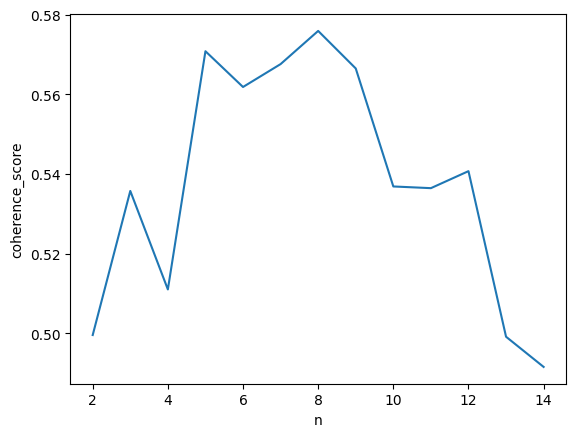

Maximum Coherence found at n:
n                  8.000000
coherence_score    0.575895
Name: 6, dtype: float64
8.0


8

In [54]:
c_coherence_df = coherence_check(child_df)
c_coherence_df

Following a similar process as the women's and men's coherence plots, it is helpful to use the elbow of the plot more than the actual maximum coherence values to get more interpretable topics given the smaller subset of news tweets being used in the LDA model. After testing 3, 5, and 8 topics, 5 resulted in somewhat more interpretable topics.

In [62]:
show_lda_vis(child_df, 5)

(0, '0.045*"child" + 0.019*"say" + 0.018*"cdc" + 0.015*"health" + 0.014*"mother"')
(1, '0.067*"kid" + 0.021*"ebola" + 0.016*"child" + 0.014*"school" + 0.014*"study"')
(2, '0.032*"child" + 0.020*"kid" + 0.017*"study" + 0.016*"smoke" + 0.015*"drug"')
(3, '0.033*"baby" + 0.029*"kid" + 0.027*"teen" + 0.013*"doctor" + 0.011*"lead"')
(4, '0.026*"baby" + 0.026*"kid" + 0.024*"youth" + 0.022*"teen" + 0.020*"study"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.146614  0.040126       1        1  22.983929
2     -0.088725  0.031783       2        1  20.900910
4      0.060650 -0.023545       3        1  20.423399
1     -0.041391 -0.150073       4        1  19.527410
0     -0.077148  0.101710       5        1  16.164352, topic_info=       Term       Freq      Total Category  logprob  loglift
43     baby  27.000000  27.000000  Default  30.0000  30.0000
25      kid  55.000000  55.000000  Default  29.0000  29.0000
1     child  36.000000  36.000000  Default  28.0000  28.0000
76    ebola   9.000000   9.000000  Default  27.0000  27.0000
312     say   6.000000   6.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
42   parent   3.439112  10.888947   Topic5  -4.4729   0.6698
257  affect   1.600899   2.572059   Topic5  -5.2376   1.3482
633   virus   2.732017   7.417758   Topic5  -4.7031   0.8235
153  infant   2.853756   8.778832   Topic5  -4.6595   0.6987
23     teen   1.624650  28.647177   Topic5  -5.2228  -1.0474

[255 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
814       4  0.526619  accept
240       3  0.906565    adhd
257       1  0.388794  affect
257       5  0.777587  affect
647       4  0.819953     age
...     ...       ...     ...
77        3  0.474360   young
77        4  0.474360   young
119       1  0.076788   youth
119       2  0.153577   youth
119       3  0.691096   youth

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

With n = 5, the topics are not very distinct from each other, but do seem to have distinctions when looking at where the salient terms are most frequent. Topic 1 seems tied to mental health or more socially discussed health issues, with highest frequency words in the topic including 'cigarette', 'obesity', 'anxious', and 'social'. Topic 1 also included 'son' as a highly frequent term, but not 'daughter', which is interesting given the other frequent words in the topic being about socially discussed health issues. Topic 2 seems to be about teen health issues, with higher frequency terms including 'drug', 'death', 'teen', 'program', and 'school'. Topic 3 is relatively difficult to interpret, with 'suicide', 'woman', and 'infant' appearing as high frequency terms. It seems to tie together generally more deadly or high-risk health news tweets. Again, 'woman' appears as a highly frequent term, but not 'man', which might be due to complications during birth mentioning women more than men. Topic 4 is about widespread disease and children, with 'ebola' being one of the highest frequency terms in it, other words including 'pediatrician' and 'vaccine'. Topic 5 seems to be about infant health, with 'mother', 'parent', and 'infant' being highly frequent terms.

Another interesting observation: while 'mother' appears as a salient term across the topics, and as a high frequency term in Topic 1 and Topic 5, 'father' does not appear in either of them, or make it to the 30 most salient terms in this data. Even with changed number of topics to 8, the term 'father' does not appear as high frequency within the topics, or high salience across documents. While this can be explained by some of the data being specific to childbirth, it is interesting to observe the lack of the term 'father' even in topics of teen health or children's mental health.

#### Discussion

This experiment with LDA was interesting in a few different ways. Here are some interesting takeaways and observations:
- **LDA for short, specific texts**: LDA does seem to work for shorter texts! While playing around with the coherence scores and number of topics was needed to get interpretable topics, there were surprisingly insightful topics, and looking at their high frequency terms was useful to get a general idea of the contents of the dataset without looking at it closely.
- **Coherence for shorter documents**: Coherence did not work conventionally as a metric for this data. It was primarily useful to get the coherence plots for any number of topics from 2 to 15, and finding the topics with the highest coherence was useful, but did not end up being the best number for interpretability in most cases. The point after which there were 'diminishing' returns for a higher number of topics, or the 'elbow' point, was a more useful metric for this. Using the LDA visualizations to get a good number of topics based on actual interpretatability of the high frequency terms in each of the topics was a great technique that used the coherence plots but did not rely on the max coherence. This might have been due to the texts being short (health tweets), the topics already being defined, resulting in generally higher coherence before modeling with LDA, or a tendency to overfit the data with a higher number of topics when the dataset is large (across all the news, not the subsets).
- **Subsetting specific subtopics using keywords**: Looking at the salient and frequent terms within the women's, men's and children's health subsets was interesting. The women's health data was generally more political, with legal and geographical terms appearing more important across specific topics, most likely due to the prevalence of abortion discussions. Meanwhile, the men's data was both smaller and had the highest coherence for only 2 topics, which were quite easy to interpret, and did not include political or children-related terms. The children's health data topics were more spread out and harder to interpret, but 5 topics did model them fairly well given the small size of the sample. The gendered split across frequent and salient terms with this data was interesting, with 'women' and 'mother' appearing important in certain topics, but not 'men' and 'father'. 